In [1]:
import pandas as pd
import numpy as np
from tree.models import UpliftRandomForestClassifier
from tree.models import PMUpliftRandomForestClassifier
from causalml.dataset import make_uplift_classification
from sklearn.model_selection import train_test_split

/home/yling/.conda/envs/yling/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df, x_names = make_uplift_classification()
df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_irrelevant,...,x12_uplift_increase,x13_increase_mix,x14_uplift_increase,x15_uplift_increase,x16_increase_mix,x17_uplift_increase,x18_uplift_increase,x19_increase_mix,conversion,treatment_effect
0,control,-0.542888,1.976361,-0.531359,-2.354211,-0.380629,-2.614321,-0.128893,0.448689,-2.275192,...,-1.315304,0.742654,1.891699,-2.428395,1.541875,-0.817705,-0.610194,-0.591581,0,0
1,treatment3,0.258654,0.552412,1.434239,-1.422311,0.089131,0.790293,1.159513,1.578868,0.166540,...,-1.391878,-0.623243,2.443972,-2.889253,2.018585,-1.109296,-0.380362,-1.667606,0,0
2,treatment1,1.697012,-2.762600,-0.662874,-1.682340,1.217443,0.837982,1.042981,0.177398,-0.112409,...,-1.132497,1.050179,1.573054,-1.788427,1.341609,-0.749227,-2.091521,-0.471386,0,0
3,treatment2,-1.441644,1.823648,0.789423,-0.295398,0.718509,-0.492993,0.947824,-1.307887,0.123340,...,-2.084619,0.058481,1.369439,0.422538,1.087176,-0.966666,-1.785592,-1.268379,1,1
4,control,-0.625074,3.002388,-0.096288,1.938235,3.392424,-0.465860,-0.919897,-1.072592,-1.331181,...,-1.403984,0.760430,1.917635,-2.347675,1.560946,-0.833067,-1.407884,-0.781343,0,0


In [3]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

## Original uplift tree model

In [4]:
uplift_model = UpliftRandomForestClassifier(control_name='control')

In [5]:
uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [6]:
y_pred_bt = uplift_model.predict(df_test[x_names].values)

In [7]:
result_bt = pd.DataFrame(y_pred_bt,
                      columns=uplift_model.classes_)

In [8]:
result_bt

,treatment1,treatment2,treatment3
0,-0.052764,0.028867,-0.001406
1,-0.080074,0.069931,0.049302
2,-0.023189,0.004354,0.029851
3,-0.033161,-0.032403,0.345702
4,0.018984,0.184651,0.202785
...,...,...,...
795,0.140050,0.121183,0.240425
796,-0.034257,0.093015,0.010059
797,-0.056127,-0.014448,-0.016414
798,0.030176,0.037918,-0.000783


## Uplift model equipped with perfect matching

In [9]:
pm_uplift = PMUpliftRandomForestClassifier(control_name='control')

In [10]:
pm_uplift.fit(df_train[x_names].values,
              treatment=df_train['treatment_group_key'].values,
              y=df_train['conversion'].values)

In [11]:
y_pred_pm = pm_uplift.predict(df_test[x_names].values)

In [12]:
result_pm = pd.DataFrame(y_pred_pm,
                      columns=uplift_model.classes_)

In [13]:
result_pm

,treatment1,treatment2,treatment3
0,0.032249,0.017559,0.009804
1,-0.005060,0.009167,0.036381
2,0.059629,0.093119,0.012388
3,0.051269,0.184628,0.216144
4,0.086869,0.182084,0.241413
...,...,...,...
795,0.004387,0.129986,0.245810
796,-0.030103,0.041780,0.093250
797,0.020709,0.126031,0.108256
798,-0.079626,-0.032172,-0.048405


## Uplift Curve

In [24]:
from causalml.metrics import plot_gain

In [17]:
best_treatment_bt = np.where((result_bt < 0).all(axis=1),
                           'control',
                           result_bt.idxmax(axis=1))
actual_is_best_bt = np.where(df_test['treatment_group_key'] == best_treatment_bt, 1, 0)
actual_is_control_bt = np.where(df_test['treatment_group_key'] == 'control', 1, 0)

In [19]:
synthetic_bt = (actual_is_best_bt == 1) | (actual_is_control_bt == 1)
synth_bt = result_bt[synthetic_bt]

In [22]:
auuc_metrics_bt = (synth_bt.assign(is_treated = 1 - actual_is_control_bt[synthetic_bt],
                             conversion = df_test.loc[synthetic_bt, 'conversion'].values,
                             uplift_tree_bt = synth_bt.max(axis=1))
                     .drop(columns=list(uplift_model.classes_)))

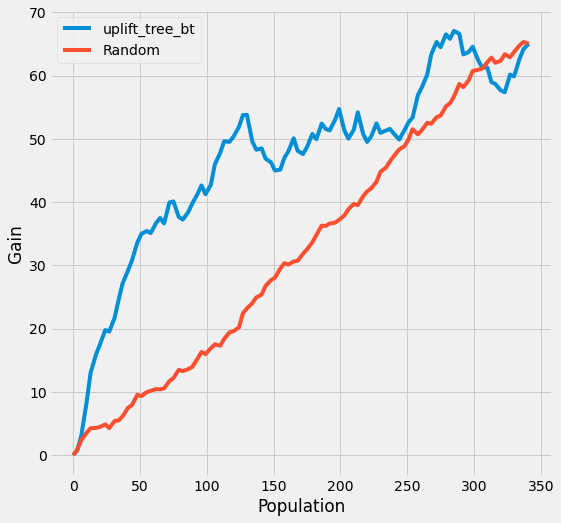

In [25]:
plot_gain(auuc_metrics_bt, outcome_col='conversion', treatment_col='is_treated')

In [27]:
best_treatment_pm = np.where((result_pm < 0).all(axis=1),
                           'control',
                           result_bt.idxmax(axis=1))
actual_is_best_pm = np.where(df_test['treatment_group_key'] == best_treatment_pm, 1, 0)
actual_is_control_pm = np.where(df_test['treatment_group_key'] == 'control', 1, 0)

In [28]:
synthetic_pm = (actual_is_best_pm == 1) | (actual_is_control_pm == 1)
synth_pm = result_bt[synthetic_pm]

In [30]:
auuc_metrics_pm = (synth_pm.assign(is_treated = 1 - actual_is_control_pm[synthetic_pm],
                             conversion = df_test.loc[synthetic_pm, 'conversion'].values,
                             uplift_tree_pm = synth_pm.max(axis=1))
                     .drop(columns=list(pm_uplift.classes_)))

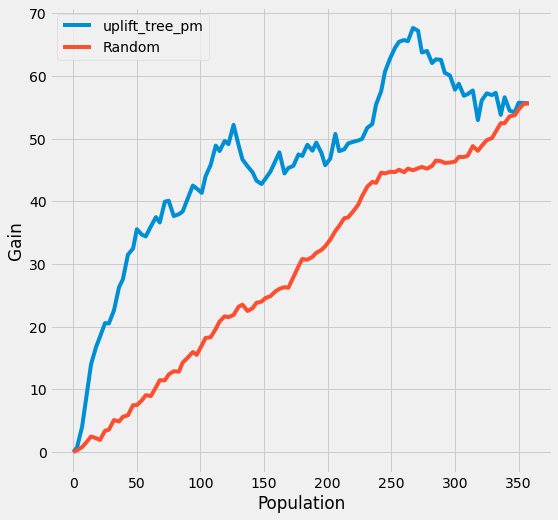

In [31]:
plot_gain(auuc_metrics_pm, outcome_col='conversion', treatment_col='is_treated')